WEEK 1 Progress

In [2]:
# 🔧 Fix environment compatibility for YOLO + OpenCV
!pip uninstall -y numpy
!pip install numpy==1.26.4
!pip install ultralytics==8.3.0 opencv-python-headless==4.9.0.80 matplotlib ipywidgets --quiet

import numpy as np
print("✅ Environment ready. NumPy version:", np.__version__)


Found existing installation: numpy 2.2.6
Uninstalling numpy-2.2.6:
  Successfully uninstalled numpy-2.2.6
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 req

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 107, in _run_wrapper
    status = _inner_run()
             ^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 98, in _inner_run
    return self.run(options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 85, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 450, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 585, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/pytho

In [1]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

model = YOLO("yolov8n.pt")  # small pretrained YOLO model
print("✅ YOLO model loaded successfully!")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ YOLO model loaded successfully!


In [2]:
from ultralytics import YOLO
import cv2
import numpy as np
import os
from google.colab import files
from IPython.display import display, Image
import matplotlib.pyplot as plt

# Helper: save image for display
def show_image(path):
    display(Image(filename=path))

# Simple greenery estimator using HSV color mask
def greenery_percentage_bgr(bgr_img):
    hsv = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV)
    # green range (tuned conservatively)
    lower = np.array([25, 40, 30])
    upper = np.array([90, 255, 255])
    mask = cv2.inRange(hsv, lower, upper)
    green_area = cv2.countNonZero(mask)
    total_area = bgr_img.shape[0] * bgr_img.shape[1]
    return (green_area / total_area) * 100, mask

# Simple smoke detector using low-saturation, medium-high value regions
def smoke_percentage_bgr(bgr_img):
    hsv = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV)
    # Smoke/white/gray tends to have low saturation and high-ish value
    lower = np.array([0, 0, 120])
    upper = np.array([179, 60, 255])
    mask = cv2.inRange(hsv, lower, upper)
    smoke_area = cv2.countNonZero(mask)
    total_area = bgr_img.shape[0] * bgr_img.shape[1]
    return (smoke_area / total_area) * 100, mask

# Eco-Score calculator (0-100)
def compute_eco_score(green_pct, smoke_pct, vehicle_count, frame_area_pixels, traffic_norm=20):
    # Normalize vehicle factor (assumes traffic_norm vehicles => high congestion)
    vehicle_factor = min(vehicle_count / max(1, traffic_norm), 1.0)
    # Simple weighted combination: greenery positive, smoke negative, traffic negative
    score = (0.6 * green_pct) - (0.8 * smoke_pct) - (30 * vehicle_factor)
    # scale and clamp to 0-100
    # green_pct and smoke_pct are percents (0-100)
    score = 50 + score  # shift so neutral ~50
    score = max(0, min(100, score))
    return int(score)

print('Helpers loaded')

Helpers loaded


In [3]:
# Upload an image or video file (run this cell and use the file picker)
print('Upload a file (image or video). After upload, run the detection cell.')
uploaded = files.upload()

# Get the first uploaded filename
if uploaded:
    input_path = list(uploaded.keys())[0]
    print('Uploaded:', input_path)
else:
    input_path = None


Upload a file (image or video). After upload, run the detection cell.


Saving traffic.jpg to traffic.jpg
Uploaded: traffic.jpg


In [4]:
# Load pretrained YOLOv8n model (downloads weights automatically first run)
model = YOLO('yolov8n.pt')
print('YOLO model loaded: yolov8n (pretrained)')

YOLO model loaded: yolov8n (pretrained)


Processing image...

image 1/1 /content/traffic.jpg: 448x640 37 cars, 1 bus, 1 truck, 551.5ms
Speed: 17.3ms preprocess, 551.5ms inference, 49.1ms postprocess per image at shape (1, 3, 448, 640)
Vehicles/pedestrians detected: 39
Greenery coverage: 1.38%
Smoke-like coverage: 22.52%
Eco-Score: 2/100


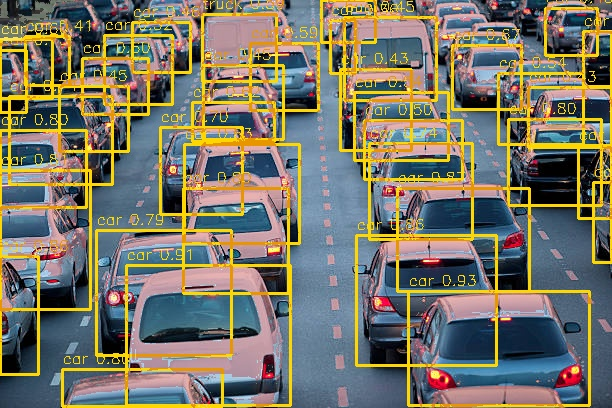

In [5]:
import os

if input_path is None:
    raise SystemExit('No input file uploaded. Upload an image or video and rerun.')

# Basic file type detection
fname = input_path
ext = os.path.splitext(fname)[1].lower()
image_exts = ['.jpg', '.jpeg', '.png', '.bmp']
video_exts = ['.mp4', '.mov', '.avi', '.mkv', '.webm']

if ext in image_exts:
    print('Processing image...')
    img = cv2.imread(fname)
    if img is None:
        raise SystemExit('Failed to read image file')

    # Run YOLO detection (vehicles & people classes among COCO)
    results = model.predict(source=fname, imgsz=640, conf=0.35, save=False)
    # results[0].boxes contains detections
    boxes = results[0].boxes
    annotated = img.copy()
    vehicle_count = 0
    for box in boxes:
        cls = int(box.cls[0])
        xyxy = box.xyxy[0].cpu().numpy().astype(int)
        conf = float(box.conf[0])
        label = model.names[cls]
        # Consider COCO vehicle/person classes
        if label in ['car','truck','bus','motorbike','bicycle','person']:
            vehicle_count += 1
            cv2.rectangle(annotated, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), (0,215,255), 2)
            cv2.putText(annotated, f"{label} {conf:.2f}", (xyxy[0], xyxy[1]-6), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,215,255), 1)

    # Greenery and smoke
    green_pct, green_mask = greenery_percentage_bgr(img)
    smoke_pct, smoke_mask = smoke_percentage_bgr(img)

    eco = compute_eco_score(green_pct, smoke_pct, vehicle_count, img.shape[0]*img.shape[1])

    out_path = 'ecovision_output_image.jpg'
    # blend masks lightly onto annotated image for visualization
    annotated_vis = annotated.copy()
    # Green overlay
    annotated_vis[green_mask>0] = cv2.addWeighted(annotated_vis, 0.7, np.stack([green_mask]*3, axis=-1), 0.3, 0)[green_mask>0]
    # Smoke overlay (red tint)
    red = np.zeros_like(annotated_vis)
    red[:,:,2] = 180
    annotated_vis[smoke_mask>0] = cv2.addWeighted(annotated_vis, 0.7, red, 0.3, 0)[smoke_mask>0]

    cv2.imwrite(out_path, annotated_vis)
    print(f"Vehicles/pedestrians detected: {vehicle_count}")
    print(f"Greenery coverage: {green_pct:.2f}%")
    print(f"Smoke-like coverage: {smoke_pct:.2f}%")
    print(f"Eco-Score: {eco}/100")
    show_image(out_path)

elif ext in video_exts:
    print('Processing video... This may take longer depending on length.')
    cap = cv2.VideoCapture(fname)
    fps = cap.get(cv2.CAP_PROP_FPS) or 25
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out_path = 'ecovision_output_video.mp4'
    out = cv2.VideoWriter(out_path, fourcc, fps, (width, height))

    frame_idx = 0
    vehicle_counts = []
    smoke_frames = []
    green_pcts = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_idx += 1
        # run YOLO on the frame (small image size for speed)
        res = model.predict(source=frame, imgsz=640, conf=0.35, save=False)
        boxes = res[0].boxes
        annotated = frame.copy()
        vehicle_count = 0
        for box in boxes:
            cls = int(box.cls[0])
            xyxy = box.xyxy[0].cpu().numpy().astype(int)
            conf = float(box.conf[0])
            label = model.names[cls]
            if label in ['car','truck','bus','motorbike','bicycle','person']:
                vehicle_count += 1
                cv2.rectangle(annotated, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), (0,215,255), 2)
                cv2.putText(annotated, f"{label} {conf:.2f}", (xyxy[0], xyxy[1]-6), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,215,255), 1)

        green_pct, green_mask = greenery_percentage_bgr(frame)
        smoke_pct, smoke_mask = smoke_percentage_bgr(frame)

        # overlay masks
        annotated_vis = annotated.copy()
        red = np.zeros_like(annotated_vis)
        red[:,:,2] = 180
        annotated_vis[green_mask>0] = cv2.addWeighted(annotated_vis, 0.7, np.stack([green_mask]*3, axis=-1), 0.3, 0)[green_mask>0]
        annotated_vis[smoke_mask>0] = cv2.addWeighted(annotated_vis, 0.7, red, 0.3, 0)[smoke_mask>0]

        # put simple stats
        cv2.putText(annotated_vis, f"Frame: {frame_idx}", (10,20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
        cv2.putText(annotated_vis, f"Vehicles: {vehicle_count}", (10,50), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)

        out.write(annotated_vis)

        vehicle_counts.append(vehicle_count)
        if smoke_pct > 1.0:  # threshold for 'smoke' presence in frame
            smoke_frames.append(frame_idx)
        green_pcts.append(green_pct)

    cap.release()
    out.release()

    avg_vehicles = int(np.mean(vehicle_counts)) if vehicle_counts else 0
    avg_green = np.mean(green_pcts) if green_pcts else 0.0
    total_smoke_frames = len(smoke_frames)
    eco = compute_eco_score(avg_green, (sum([0 for _ in smoke_frames]) if False else (total_smoke_frames/ max(1, frame_idx))*100), avg_vehicles, width*height)

    print(f"Average vehicles per frame: {avg_vehicles}")
    print(f"Frames with detectable smoke: {smoke_frames[:10]}{'...' if len(smoke_frames)>10 else ''}")
    print(f"Average greenery coverage: {avg_green:.2f}%")
    print(f"Eco-Score (approx): {eco}/100")
    print('Output saved to', out_path)

    # show a few frames from the output
    from IPython.display import HTML
    from base64 import b64encode
    mp4 = open(out_path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display(HTML(f"<video width=640 controls src='{data_url}'></video>"))

else:
    raise SystemExit('Unsupported file type. Upload an image or video.')